In [327]:
import random
from copy import deepcopy

import pandas as pd
import numpy as np
from scipy.special import logsumexp

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.metrics import accuracy_score, f1_score

In [38]:
eps = 1e-9

SEED = 18092025
random.seed(SEED)
np.random.seed(SEED)

rng = np.random.default_rng(seed=SEED)

[Датасет](https://archive.ics.uci.edu/dataset/697/predict+students+dropout+and+academic+success)

In [39]:
try:
    df = pd.read_csv('../datasets/data.csv', delimiter=';')
except Exception:
    print('No such file')

In [40]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.width', None)

pd.set_option('display.expand_frame_repr', False)


# pd.reset_option('display.max_columns')
# pd.reset_option('display.max_colwidth')
# pd.reset_option('display.width')
# pd.reset_option('display.expand_frame_repr')

---

## EDA

In [41]:
def display_nans(df):
    nans_per_col = [(col, df[col].isna().sum(), df[col].isna().sum() / df.shape[0] * 100) for col in df.columns]
    dtype = [('col_name', 'U20'), ('nans', int), ('nans_perc', float)]
    nans_per_col = np.array(nans_per_col, dtype=dtype)
    nans_per_col = nans_per_col[nans_per_col['nans'] > 0]
    nans_per_col = np.sort(nans_per_col, order='nans')

    if nans_per_col.shape[0] == 0:
        print('No nans in the dataset')
        return

    df_show = pd.DataFrame(nans_per_col[::-1])
    display(df_show.style.background_gradient(cmap='Blues'))
    
    fig, ax = plt.subplots(1, 1, figsize=(8, 5))

    y_pos = np.arange(len(nans_per_col))
    
    ax.barh(y_pos, nans_per_col['nans_perc'], alpha=0.8, edgecolor='black', linewidth=1) 
    ax.set_yticks(y_pos, labels=nans_per_col['col_name'])
    ax.set_xlabel('Nans, %', fontsize=14)
    ax.set_title('Nans rate for each column', fontsize=16)
    ax.set_xlim(0, min(np.max(df_show['nans_perc']) + 5.0, 100.0))
    ax.tick_params(axis='both', which='major', labelsize=11)
    ax.grid(axis='x', linestyle='--', linewidth=0.5)
    
    plt.show()

In [42]:
display(df.head())
print('Dataset shape: ', df.shape)

,Marital status,Application mode,Application order,Course,Daytime/evening attendance\t,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,Father's qualification,Mother's occupation,Father's occupation,Admission grade,Displaced,Educational special needs,Debtor,Tuition fees up to date,Gender,Scholarship holder,Age at enrollment,International,Curricular units 1st sem (credited),Curricular units 1st sem (enrolled),Curricular units 1st sem (evaluations),Curricular units 1st sem (approved),Curricular units 1st sem (grade),Curricular units 1st sem (without evaluations),Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target
0,1,17,5,171,1,1,122.0,1,19,12,5,9,127.3,1,0,0,1,1,0,20,0,0,0,0,0,0.000000,0,0,0,0,0,0.000000,0,10.8,1.4,1.74,Dropout
1,1,15,1,9254,1,1,160.0,1,1,3,3,3,142.5,1,0,0,0,1,0,19,0,0,6,6,6,14.000000,0,0,6,6,6,13.666667,0,13.9,-0.3,0.79,Graduate
2,1,1,5,9070,1,1,122.0,1,37,37,9,9,124.8,1,0,0,0,1,0,19,0,0,6,0,0,0.000000,0,0,6,0,0,0.000000,0,10.8,1.4,1.74,Dropout
3,1,17,2,9773,1,1,122.0,1,38,37,5,3,119.6,1,0,0,1,0,0,20,0,0,6,8,6,13.428571,0,0,6,10,5,12.400000,0,9.4,-0.8,-3.12,Graduate
4,2,39,1,8014,0,1,100.0,1,37,38,9,9,141.5,0,0,0,1,0,0,45,0,0,6,9,5,12.333333,0,0,6,6,6,13.000000,0,13.9,-0.3,0.79,Graduate


Dataset shape:  (4424, 37)


In [48]:
def col_names_transform(col_name: str) -> str:
    res_name = col_name.strip().replace("\t", "").replace(' ', '_').lower()
    return res_name

In [49]:
df.columns = map(col_names_transform, df.columns.values)
df.columns

Index(['marital_status', 'application_mode', 'application_order', 'course',
       'daytime/evening_attendance', 'previous_qualification',
       'previous_qualification_(grade)', 'nacionality',
       'mother's_qualification', 'father's_qualification',
       'mother's_occupation', 'father's_occupation', 'admission_grade',
       'displaced', 'educational_special_needs', 'debtor',
       'tuition_fees_up_to_date', 'gender', 'scholarship_holder',
       'age_at_enrollment', 'international',
       'curricular_units_1st_sem_(credited)',
       'curricular_units_1st_sem_(enrolled)',
       'curricular_units_1st_sem_(evaluations)',
       'curricular_units_1st_sem_(approved)',
       'curricular_units_1st_sem_(grade)',
       'curricular_units_1st_sem_(without_evaluations)',
       'curricular_units_2nd_sem_(credited)',
       'curricular_units_2nd_sem_(enrolled)',
       'curricular_units_2nd_sem_(evaluations)',
       'curricular_units_2nd_sem_(approved)',
       'curricular_units_2nd_s

In [50]:
df.describe()

,marital_status,application_mode,application_order,course,daytime/evening_attendance,previous_qualification,previous_qualification_(grade),nacionality,mother's_qualification,father's_qualification,mother's_occupation,father's_occupation,admission_grade,displaced,educational_special_needs,debtor,tuition_fees_up_to_date,gender,scholarship_holder,age_at_enrollment,international,curricular_units_1st_sem_(credited),curricular_units_1st_sem_(enrolled),curricular_units_1st_sem_(evaluations),curricular_units_1st_sem_(approved),curricular_units_1st_sem_(grade),curricular_units_1st_sem_(without_evaluations),curricular_units_2nd_sem_(credited),curricular_units_2nd_sem_(enrolled),curricular_units_2nd_sem_(evaluations),curricular_units_2nd_sem_(approved),curricular_units_2nd_sem_(grade),curricular_units_2nd_sem_(without_evaluations),unemployment_rate,inflation_rate,gdp
count,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000
mean,1.178571,18.669078,1.727848,8856.642631,0.890823,4.577758,132.613314,1.873192,19.561935,22.275316,10.960895,11.032324,126.978119,0.548373,0.011528,0.113698,0.880651,0.351718,0.248418,23.265145,0.024864,0.709991,6.270570,8.299051,4.706600,10.640822,0.137658,0.541817,6.232143,8.063291,4.435805,10.230206,0.150316,11.566139,1.228029,0.001969
std,0.605747,17.484682,1.313793,2063.566416,0.311897,10.216592,13.188332,6.914514,15.603186,15.343108,26.418253,25.263040,14.482001,0.497711,0.106760,0.317480,0.324235,0.477560,0.432144,7.587816,0.155729,2.360507,2.480178,4.179106,3.094238,4.843663,0.690880,1.918546,2.195951,3.947951,3.014764,5.210808,0.753774,2.663850,1.382711,2.269935
min,1.000000,1.000000,0.000000,33.000000,0.000000,1.000000,95.000000,1.000000,1.000000,1.000000,0.000000,0.000000,95.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,17.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.600000,-0.800000,-4.060000
25%,1.000000,1.000000,1.000000,9085.000000,1.000000,1.000000,125.000000,1.000000,2.000000,3.000000,4.000000,4.000000,117.900000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,19.000000,0.000000,0.000000,5.000000,6.000000,3.000000,11.000000,0.000000,0.000000,5.000000,6.000000,2.000000,10.750000,0.000000,9.400000,0.300000,-1.700000
50%,1.000000,17.000000,1.000000,9238.000000,1.000000,1.000000,133.100000,1.000000,19.000000,19.000000,5.000000,7.000000,126.100000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,20.000000,0.000000,0.000000,6.000000,8.000000,5.000000,12.285714,0.000000,0.000000,6.000000,8.000000,5.000000,12.200000,0.000000,11.100000,1.400000,0.320000
75%,1.000000,39.000000,2.000000,9556.000000,1.000000,1.000000,140.000000,1.000000,37.000000,37.000000,9.000000,9.000000,134.800000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,25.000000,0.000000,0.000000,7.000000,10.000000,6.000000,13.400000,0.000000,0.000000,7.000000,10.000000,6.000000,13.333333,0.000000,13.900000,2.600000,1.790000
max,6.000000,57.000000,9.000000,9991.000000,1.000000,43.000000,190.000000,109.000000,44.000000,44.000000,194.000000,195.000000,190.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,70.000000,1.000000,20.000000,26.000000,45.000000,26.000000,18.875000,12.000000,19.000000,23.000000,33.000000,20.000000,18.571429,12.000000,16.200000,3.700000,3.510000


In [53]:
# TODO: добавить другие стат. показатели 

In [51]:
display_nans(df)

No nans in the dataset


In [52]:
df.dtypes

marital_status                                      int64
application_mode                                    int64
application_order                                   int64
course                                              int64
daytime/evening_attendance                          int64
previous_qualification                              int64
previous_qualification_(grade)                    float64
nacionality                                         int64
mother's_qualification                              int64
father's_qualification                              int64
mother's_occupation                                 int64
father's_occupation                                 int64
admission_grade                                   float64
displaced                                           int64
educational_special_needs                           int64
debtor                                              int64
tuition_fees_up_to_date                             int64
gender        

In [61]:
df['target'].value_counts(normalize=True).to_frame().T

target,Graduate,Dropout,Enrolled
proportion,0.499322,0.321203,0.179476


---

## Подготовка данных

In [55]:
X, y = df.drop(columns=['target']), df['target']
X.shape, y.shape

((4424, 36), (4424,))

In [56]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED, shuffle=True, stratify=y)
y_train.shape, y_test.shape

((3539,), (885,))

In [57]:
std_scaler = StandardScaler()
X_train_scaled = std_scaler.fit_transform(X_train)
X_test_scaled  = std_scaler.transform(X_test)
X_train_scaled[0, :5]

array([-0.29563934, -0.0374792 , -0.55645717,  0.31315804,  0.34938119])

In [58]:
label_encoder = LabelEncoder()
y_train_enc = label_encoder.fit_transform(y_train.values)
y_test_enc  = label_encoder.transform(y_test.values)
y_train[:5].values, y_train_enc[:5], label_encoder.classes_

(array(['Graduate', 'Dropout', 'Dropout', 'Enrolled', 'Dropout'],
       dtype=object),
 array([2, 0, 0, 1, 0]),
 array(['Dropout', 'Enrolled', 'Graduate'], dtype=object))

---

## Модель линейной классификации

In [666]:
class LogRegNumpy():

    def __init__(
        self,
        initial_weights: list[list[float]] = [], # (n_features, n_classes)
        initial_bias:    list[float] = [],       # (1, n_classes)
        tolerance:       float = 1e-4,
        early_stop: bool = False,
        n_startup_rounds: int = 50,
        early_stop_rounds: int = 50,
        random_seed: int = SEED
    ):
        self.weights = np.array(initial_weights) if not isinstance(initial_weights, np.ndarray) else initial_weights
        self.bias = np.array(initial_bias) if not isinstance(initial_bias, np.ndarray) else initial_bias
        self.tolerance = tolerance
        self.early_stop = early_stop
        self.n_startup_rounds = n_startup_rounds
        self.early_stop_rounds = early_stop_rounds
        self.random_seed = random_seed
        self.eps = 1e-9

    def fit(
        self,
        features:      list[list[float]],
        labels:        list[int],
        learning_rate: float = 1e-3,
        epochs:        int = 100,
        return_weights_history: bool = False,
        verbose:       bool = False
    ) -> None | list[list[float]]:
        X = np.array(features).squeeze() if not isinstance(features, np.ndarray) else deepcopy(features)
        y = np.array(labels).squeeze() if not isinstance(labels, np.ndarray) else deepcopy(labels)

        self.init_weights(X, y)

        loss_values = []
        if return_weights_history:
            weights_values = []
            weights_values.append(self.weights.copy())
            
        no_improvement_counter = 0

        for epoch in range(epochs):
            logits = self.forward(X)
            loss = self.loss_fn(y, logits)

            if self.early_stop:
                if epoch > self.n_startup_rounds and 0 < (loss_values[-1] - loss) < self.tolerance:
                    no_improvement_counter += 1
                    if no_improvement_counter >= self.early_stop_rounds:
                        print(f"Early stopping at epoch {epoch}")
                        break
                else:
                    no_improvement_counter = 0

            loss_values.append(loss)
            if return_weights_history:
                weights_values.append(self.weights.copy())
            
            w_grad, b_grad = self.gradient(X, y, logits)
            self.weights -= learning_rate * w_grad
            self.bias -= learning_rate * b_grad

        self.loss_values = loss_values

        if return_weights_history:
            return np.array(weights_values)


    def predict(self, features: list[list[float]]):
        X = np.array(features).squeeze() if not isinstance(features, np.ndarray) else deepcopy(features)
        X = self.add_ones(X)

        w = np.hstack([self.bias, self.weights])

        probs = self.forward(X, w)

        return np.argmax(probs)
    
    def create_onehot_target(self, y: np.array):
        ohe_enc = OneHotEncoder(categories=[np.unique(y)], sparse_output=False)
        y_enc = ohe_enc.fit_transform(y.reshape(-1, 1))
        return y_enc # output -> (n_samples, n_classes)
    
    def init_weights(self, X, y):
        rng_ = np.random.default_rng(seed=self.random_seed)
        n_unique_classes = np.unique(y).shape[0]
        if self.weights.size == 0:
            self.weights = rng_.standard_normal((X.shape[1], n_unique_classes), dtype=np.float32)
        if self.bias.size == 0:
            self.bias = rng_.standard_normal((1, n_unique_classes), dtype=np.float32)
        
    def softmax(self, X: np.array) -> np.array:
        Z = X - np.max(X, axis=1).reshape(-1, 1)
        numerator = np.exp(Z)
        denominator = np.sum(numerator, axis=1).reshape(-1, 1)
        softmax_probs = numerator / denominator
        return softmax_probs # -> (n_samples, n_classes)
    
    def forward(self, X):
        # (n_samples, n_features) * (n_features, n_classes)
        logits = np.matmul(X, self.weights) + self.bias # -> (n_samples, n_classes)
        return logits # probabilities
    
    def loss_fn_expanded(self, X, y_true):
        # (n_samples, n_features) * (n_features, n_classes) + (n_samples, 1) * (1, n_classes) = (n_samples, n_classes)
        logits = np.matmul(X, self.weights) + np.matmul(np.ones((X.shape[0], 1)), self.bias)
        exp_logits = np.exp(logits)
        logits_sum = np.sum(exp_logits, axis=1) # -> (n_samples, 1)
        # (n_samples, n_classes) * (n_samples, n_classes)
        true_class_logits = logits[np.arange(X.shape[0]), y_true]
        return np.mean(np.log(logits_sum) - true_class_logits)

    def loss_fn(self, y_true, logits):
        log_probs = np.log(self.softmax(logits)) # -> (n_samples, classes)
        # y_true_ohe = self.create_onehot_target(y_true) # -> (n_samples, classes)
        # likelihood = (log_probs * y_true_ohe).sum(axis=1).mean()
        likelihood = (log_probs[np.arange(log_probs.shape[0]), y_true]).mean()
        return -likelihood
    
    def loss_fn_opt(self, y_true, logits):
        lse = logsumexp(logits, axis=1, keepdims=True)
        log_P = logits - lse
        return -(log_P[np.arange(log_P.shape[0]), y_true]).mean()
    
    def gradient(self, X, y_true, logits):
        y_prob = self.softmax(logits)
        y_prob[np.arange(y_prob.shape[0]), y_true] -= 1
        w_grad = np.matmul(X.T, y_prob) / y_prob.shape[0] # как через mean?
        b_grad = y_prob.mean(axis=0).reshape(1, -1)
        return w_grad, b_grad

In [667]:
tmp = LogRegNumpy()

In [671]:
tmp.fit(X_train_scaled, y_train_enc, learning_rate=0.01)

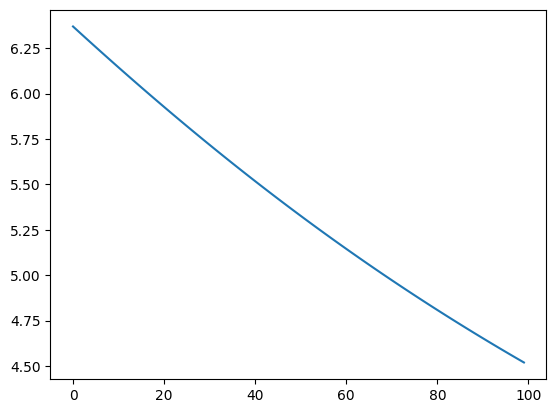

In [672]:
plt.plot(tmp.loss_values)